In [1]:
using DifferentialEquations
using StochasticDelayDiffEq
using SpecialFunctions
using Plots
using XLSX
using Turing
using Distributions
using SimulatedAnnealingABC

In [2]:
# EXTRACTING OPEN MAGNETIC FLUX AND SUNSPOT NUMBER RECORDS FROM XLSX FILE

# Initialize vectors
years = Vector{Float64}()
open_magn_flux = Vector{Float64}()
open_magn_flux_err = Vector{Float64}()
ssa_open_magn_flux = Vector{Float64}()
sunsopts_num = Vector{Float64}()
sunspots_err = Vector{Float64}()
ssa_sunspots = Vector{Float64}()

# Read from xlsx file the data
XLSX.openxlsx("SN Usoskin Brehm.xlsx") do file
  sheet = file["Data"]

  for row in XLSX.eachrow(sheet)
    year = row[2]
    omf = row[3]
    omf_err = row[4]
    omf_ssa = row[5]
    sun_num = row[7]
    sun_err = row[8]
    sun_ssa = row[9]
    
    # Check if the rows values are numeric (and not empty nor strings)
    if isa(year, Number)
      push!(years, year)
      push!(open_magn_flux, omf)
      push!(open_magn_flux_err, omf_err)
      push!(ssa_open_magn_flux, omf_ssa)
      push!(sunsopts_num, sun_num)
      push!(sunspots_err, sun_err)
      push!(ssa_sunspots, sun_ssa)
    end
  end
end

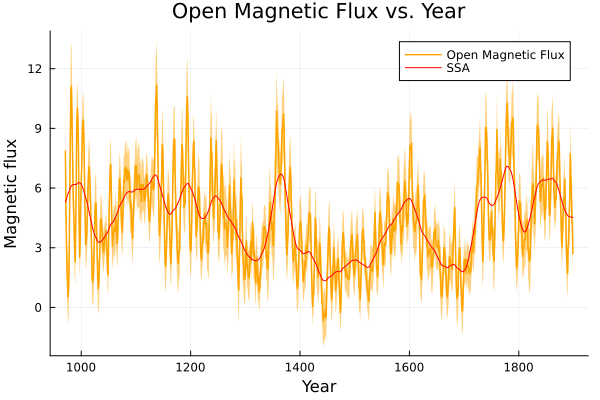

In [3]:
# PLOTTING OF THE OPEN MAGNETIC FLUX RECORDS FROM 971 TO 1899 (AD)

plot(years, open_magn_flux, ribbon = open_magn_flux_err, xlabel = "Year", ylabel = "Magnetic flux", 
    title = "Open Magnetic Flux vs. Year", label = "Open Magnetic Flux", linewidth = 1.5, color = "orange")
plot!(years, ssa_open_magn_flux, label = "SSA", linewidth = 1, color = "red")

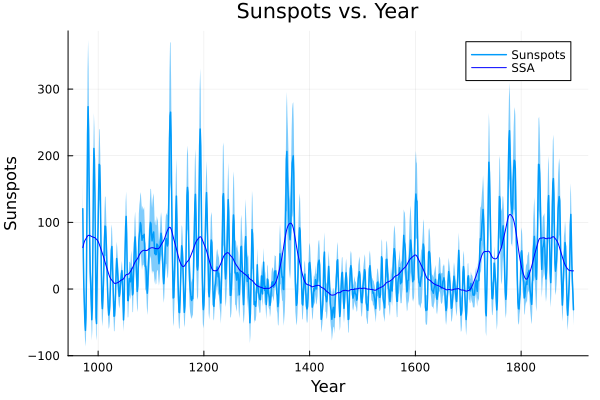

In [4]:
# PLOTTING OF THE SUNSPOT RECORDS FROM 971 TO 1899 (AD)

plot(years, sunsopts_num, ribbon = sunspots_err, xlabel = "Year", ylabel = "Sunspots", 
    title = "Sunspots vs. Year", label = "Sunspots", linewidth = 1.5)
plot!(years, ssa_sunspots, label = "SSA", linewidth = 1, color = "blue")

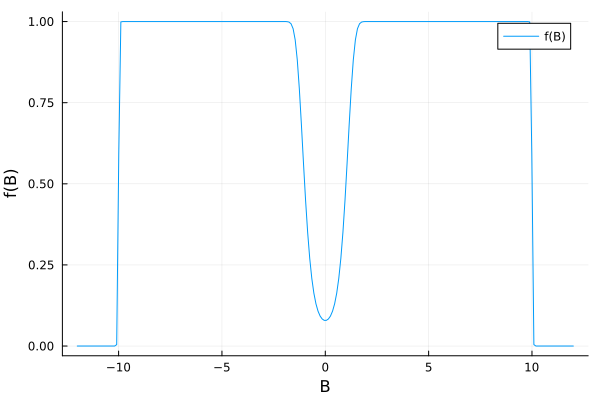

In [5]:
# BOX-SHAPED FUNCTION FOR THE MAGNETIC FIELD RANGE

# Define limits
B_min = 1
B_max = 10

# Define the function
function f(B)
    return 1 / 4 * (1 .+ erf.(B .^ 2 .- B_min ^ 2)) .* (1 .- erf.(B .^ 2 .- B_max ^ 2))
end

# Plot (range [-12, 12])
B_values = range(-12, stop = 12, length = 240)
f_values = f(B_values)
plot(B_values, f_values, xlabel = "B", ylabel = "f(B)", label = "f(B)")

##############################################################

# DIMENSION OF THE MAGNETIC FIELD???

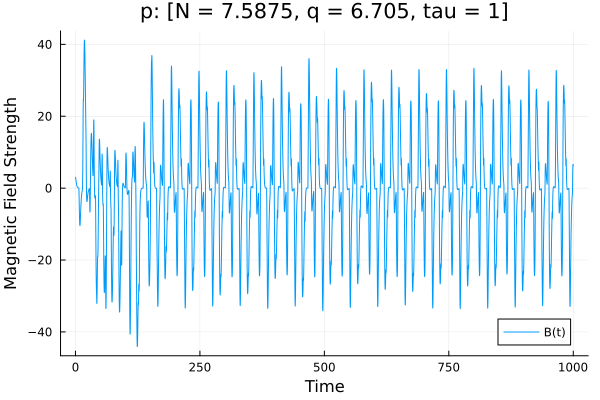

In [10]:
# DDE PROBLEM WITHOUT NOISE AND PERIODIC MODULATION

# Define parameters
N = 8.4
T0 = 0.52
T1 = 0.3
tau = 1
q = (T0 + T1) / tau
N = 7.5875
q = 6.7050
p = [N, q, tau]

# Define initial conditions
B0 = [3, 0]
tspan = (0, 1000)
h(p, t) = [0.0, 0.0]

# Define the function for the DDE
function MagneticField(du, u, h, p, t)
  N, q, tau = p

  B = u[1]
  dB = u[2]

  du[1] = dB
  du[2] = - ((2 / tau) * dB + (B / tau^2) + N * h(p, t - q)[1] * f(h(p, t - q)[1]))
end

# Define and solve the DDE problem
prob = DDEProblem(MagneticField, B0, h, tspan, p)
sol = solve(prob, MethodOfSteps(Tsit5()), saveat = 0.01)

# Plot 
plot(sol.t, sol[1, :], label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength", title = "p: [N = $N, q = $q, tau = $tau]", linewidth = 1)
#plot!(sol.t, sol[2, :], label="dB/dt", linewidth=1)
#plot!(sol.t, sol[3, :], label="d^2B/dt^2", linewidth=1)

In [7]:
y_obs = sunsopts_num

# Modello Bayesian con Turing
@model function bayesian_model(y_obs)
    N ~ Uniform(0, 10)
    q ~ Uniform(0, 10)
    tau = 1

    # Condizioni iniziali e setup ODE
    tspan = (0.0, length(y_obs))
    p = [N, q, tau]
    
    # Risolvi l'ODE
    prob = DDEProblem(MagneticField, B0, h, tspan, p)
    solution = solve(prob, MethodOfSteps(Tsit5()), saveat = 0.01)
    B_solution = [sol[1] for sol in solution.u]

    # Likelihood
    for i in 1:length(y_obs)
        y_obs[i] ~ Normal(B_solution[i], 1.0)
    end
end

# Esecuzione MCMC
model = bayesian_model(y_obs)
chain = sample(model, NUTS(), 100)

┌ Info: Found initial step size
└   ϵ = 0.003125
Sampling: 100%|█████████████████████████████████████████| Time: 1:02:11


Chains MCMC chain (100×14×1 Array{Float64, 3}):

Iterations        = 51:1:150
Number of chains  = 1
Samples per chain = 100
Wall duration     = 3770.28 seconds
Compute duration  = 3770.28 seconds
parameters        = N, q
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

           N    7.5881    0.0004    0.0003     1.4066    16.4027    2.0906     ⋯
           q    6.7050    0.0000    0.0000    35.9513    52.4503    1.0705     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

         

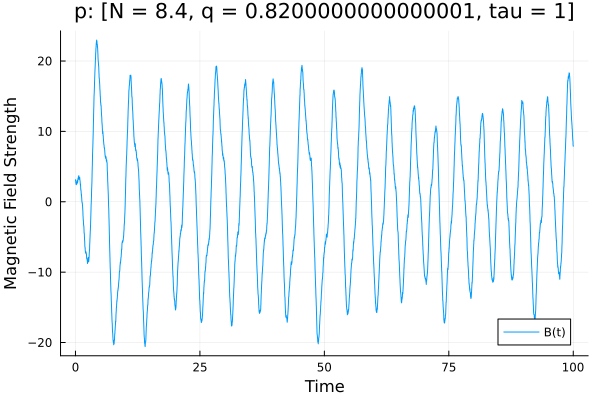

In [8]:
# SDDE PROBLEM WITHOUT PERIODIC MODULATION

# Define parameters
N = 8.4
T0 = 0.52
T1 = 0.3
tau = 1
q = (T0 + T1) / tau
sigma = 0.1
params = [N, q, tau, sigma, B_max]

# Define initial conditions
B0 = [3, 0]
tspan = (0, 100)
h(p, t) = [0.0, 0.0]

# Define noise initial conditions
noise0 = [1.0]

# Define the function for the DDE
function MagneticField(du, u, h, p, t)
  N, q, tau, sigma, Bmax = p

  B = u[1]
  dB = u[2]

  du[1] = dB
  du[2] = - ((2 / tau) * dB + (B / tau^2) + N * h(p, t - q)[1] * f(h(p, t - q)[1]))
end

function noise(du, u, h, p, t)
  N, q, tau, sigma, Bmax = p
  du[1] = (sigma * Bmax)
end

# Define and solve the SDDE problem
prob = SDDEProblem(MagneticField, noise, B0, h, tspan, params)
sol = solve(prob, EM(), dt = 0.01)

# Plot 
plot(sol.t, sol[1, :], label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength", title = "p: [N = $N, q = $q, tau = $tau]", linewidth = 1)
#plot!(sol.t, sol[2, :], label="dB/dt", linewidth=1)
#plot!(sol.t, sol[3, :], label="d^2B/dt^2", linewidth=1)

In [5]:
using Distances

## Generate data
# ----------------- #
Random.seed!()
true_mean = 3; true_sigma = 15
num_samples = 100
yobs = rand(Normal(true_mean, true_sigma), num_samples)
# ----------------- #

## Summary stats for obsrevations
# ----------------- #
s1obs = mean(yobs); s2obs = std(yobs) 
ss_obs = [s1obs, s2obs]
# ----------------- #

## Define prior
# ----------------- #
s1_min = -10; s1_max = 20    # stat 1 (distribution mean)
s2_min = 0; s2_max = 25      # stat 2 (distribution std)
prior = product_distribution(Uniform(s1_min, s1_max), Uniform(s2_min, s2_max))
# ----------------- #

## Model + distance function
## N.B.: DISTANCE MUST BE A VECTOR CONTAINING INDIVIDUAL DISTANCES FOR EACH STAT
# ----------------- #
function f_dist(θ)
	# Data-generating model
	y = rand(Normal(θ[1],θ[2]), num_samples)
	# Summary stats
	s1 = mean(y); s2 = std(y)
	ss = [s1, s2]
	# DistancE
	rho = [euclidean(ss[ix], ss_obs[ix]) for ix in 1:size(ss,1)]
	return rho
end
# ----------------- #

## Sample Posterior
# ----------------- #
nsim = 2_000_000  # total number of particle updates
# --- TYPE 1 -> single-epsilon ---
out_singeps = sabc(f_dist, prior; n_particles = 1000, v = 1.0, n_simulation = nsim)
display(out_singeps)
# --- TYPE 2 -> multi-epsilon ---
#out_multeps = sabc(f_dist, prior; n_particles = 1000, v = 10.0, n_simulation = nsim, type = 2)
#display(out_multeps)
# --- TYPE 3 -> hybrid multi-u-single-epsilon ---
#out_hybrid = sabc(f_dist, prior; n_particles = 1000, v = 1.0, n_simulation = nsim, type = 3)
#display(out_hybrid)
# ----------------- #

## Extract posterior population, trajectories for epsilon, rho and u
# ----------------- #
pop_singeps = hcat(out_singeps.population...)
eps_singeps = hcat(out_singeps.state.ϵ_history...)
rho_singeps = hcat(out_singeps.state.ρ_history...)
u_singeps = hcat(out_singeps.state.u_history...)

#pop_multeps = hcat(out_multeps.population...)
#eps_multeps = hcat(out_multeps.state.ϵ_history...)
#rho_multeps = hcat(out_multeps.state.ρ_history...)
#u_multeps = hcat(out_multeps.state.u_history...)
#
#pop_hybrid = hcat(out_hybrid.population...)
#eps_hybrid = hcat(out_hybrid.state.ϵ_history...)
#rho_hybrid = hcat(out_hybrid.state.ρ_history...)
#u_hybrid = hcat(out_hybrid.state.u_history...)

### Update existing population with another 1_000_000 simulations
## ----------------- #
#v = 1.0   # v = 10 for multi-epsilon
## replace 'out' with out_singeps, out_multeps or out_hybrid
## choose the corresponding type for the algorithm
#type = 1,2 or 3
#update_population!(out, f_dist, prior; v = v, n_simulation = 10_000, type = type)

[ Info: Using threads: 1 
[ Info: Initializing population...
[ Info: Initial resampling (δ = 0.1) - ESS = 993.4707669793873 
[ Info: Population with 1000 particles initialised.
[ Info: Initial ϵ = [1.1841562107135892, 1.1881988733939106]
[ Info: 2024-04-30T20:14:19.064 -- Starting population updates.
[ Info: Resampling 2 (δ = 0.1) - ESS = 986.5189085780092
[ Info: Resampling 3 (δ = 0.1) - ESS = 984.7140559374683
[ Info: Resampling 4 (δ = 0.1) - ESS = 982.9384602152352
[ Info: Resampling 5 (δ = 0.1) - ESS = 979.8676147627531
[ Info: Resampling 6 (δ = 0.1) - ESS = 979.4137495750156
┌ Info: 2024-04-30T20:14:20.917 -- Update 100 of 1999 -- ETA: 00:00:35 
│  ϵ: [0.0008138, 0.0008738] 
└  mean transformed distance: 0.01342 
┌ Info: 2024-04-30T20:14:22.211 -- Update 200 of 1999 -- ETA: 00:00:28 
│  ϵ: [0.0003218, 0.0003461] 
└  mean transformed distance: 0.008344 
[ Info: Resampling 7 (δ = 0.1) - ESS = 984.1694194509465
┌ Info: 2024-04-30T20:14:23.241 -- Update 300 of 1999 -- ETA: 00:00:23 
│

Approximate posterior sample with 1000 particles:
  - simulations used: 2000000
  - average transformed distance: 0.001961
  - ϵ: [2.325e-5, 1.395e-5]
  - population resampling: 7
  - acceptance rate: 0.00797
The sample can be accessed with the field `population`.
The history of ϵ can be accessed with the field `state.ϵ_history`.
 -------------------------------------- 


2×2000 Matrix{Float64}:
 0.487691  0.467502  0.442346  …  0.00158284  0.00158219  0.00158219
 0.486446  0.46395   0.441289     0.0023401   0.00233899  0.00233899